In [1]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import Transformer
import torch.nn.functional as F
from torch import Tensor
from torch import nn
from typing import List, Union
import warnings
import random
import torch
import math
import yaml
import json
import os
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
warnings.filterwarnings("ignore")

In [2]:
from IPython import get_ipython

def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def before_cell_run(info):
    set_seed(42)

ip = get_ipython()
ip.events.register('pre_run_cell', before_cell_run)

In [3]:
class Tokenizer:
    def __init__(self, root: str):
        config_path = os.path.join(root, 'tokenizer.yaml')
        if not os.path.exists(config_path):
            raise FileNotFoundError(f"{config_path} not found.")
        
        with open(config_path, 'r') as f:
            self.tokenizer = yaml.load(f, Loader=yaml.CLoader)
        
        self.char_2_index = self.tokenizer['char_2_index']
        self.index_2_char = self.tokenizer['index_2_char']
        self.padding_token = self.char_2_index.get('[pad]')
        self.start_token = self.char_2_index.get('[sos]')
        self.end_token = self.char_2_index.get('[eos]')
        
    def tokenize(self, text: str) -> List[int]:
        return [self.char_2_index.get(char, self) for char in text]

    def detokenize(self, indices: Union[List[int], 'Tensor'], without_token: bool = True) -> str:
        if hasattr(indices, 'tolist'):
            indices = indices.tolist()
        
        result = ''.join(self.index_2_char.get(i, '[unk]') for i in indices)
        
        if without_token:
            result = result.split('[eos]', 1)[0].replace('[sos]', '').replace('[eos]', '').replace('[pad]', '')
        
        return result

In [4]:
def metrics(pred:list, target:list) -> float:
    """
    pred: list of strings
    target: list of strings

    return: accuracy(%)
    """
    if len(pred) != len(target):
        raise ValueError('length of pred and target must be the same')
    correct = 0
    for i in range(len(pred)):
        if pred[i] == target[i]:
            correct += 1
    return correct / len(pred) * 100

In [5]:
embedding_num = 29
embedding_dim = 512
num_layers = 6
num_heads = 8
ff_dim = 2048
dropout = 0.1

In [6]:
class SpellCorrectionDataset(Dataset):
    def __init__(self, root, tokenizer: Tokenizer, split:str = 'train', padding:int =0):
        super(SpellCorrectionDataset, self).__init__()
        self.padding = padding
        self.tokenizer = tokenizer
        self.data = self.load_data(root, split)

        expanded_data = []
        for sample in self.data:
            for src_text in sample['input']:
                expanded_data.append({'input': src_text, 'target': sample['target']})

        self.data = expanded_data
        
    def load_data(self, root, split):
        with open(os.path.join(root, f'{split}.json'), 'r') as f:
            return json.load(f)
    
    def __len__(self):
        return len(self.data)
    
    def padding_ids(self, ids:list) -> List[int]:
        return ids + [self.tokenizer.padding_token] * (self.padding - len(ids))

    def __getitem__(self, index):
        sample = self.data[index]
        input_ids = self.tokenizer.tokenize(sample['input'])
        target_ids = self.tokenizer.tokenize(sample['target'])

        input_ids = self.padding_ids(
            [self.tokenizer.start_token] +
            input_ids +
            [self.tokenizer.end_token]
        )
        target_ids = self.padding_ids(
            [self.tokenizer.start_token] +
            target_ids +
            [self.tokenizer.end_token]
        )
        
        return torch.tensor(input_ids), torch.tensor(target_ids)

In [7]:
t = Tokenizer('data')
test2set = SpellCorrectionDataset('data', t, 'test2', 128)
test2loader = DataLoader(test2set, batch_size=1, shuffle=False)

for i, (input_ids, target_ids) in enumerate(test2loader):
    print(input_ids)
    print(target_ids)

    print(t.detokenize(input_ids[0]))
    print(t.detokenize(target_ids[0]))
    break

tensor([[ 1,  3, 15,  7, 20,  3,  5,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0]])
tensor([[ 1,  3, 15,  7, 20, 11,  5,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         

In [8]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000, batch_first: bool = False):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        self.batch_first = batch_first

    def forward(self, x: Tensor) -> Tensor:
        if self.batch_first:
            x = x.transpose(0, 1)
            x = x + self.pe[:x.size(0)]
            return self.dropout(x.transpose(0, 1))
        else:
            x = x + self.pe[:x.size(0)]
            return self.dropout(x)

In [9]:
class Encoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100):
        super(Encoder, self).__init__()
        self.tok_embedding = nn.Embedding(num_emb, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout, max_length, batch_first=True)
        self.layer = nn.TransformerEncoderLayer(d_model=hid_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.layer, num_layers=n_layers)
        self.hid_dim = hid_dim

    def forward(self, src, src_key_padding_mask):
        src = self.tok_embedding(src) * math.sqrt(self.hid_dim)
        src = self.pos_embedding(src)
        src = self.encoder(src, src_key_padding_mask=src_key_padding_mask)

        return src

class Decoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100):
        super(Decoder, self).__init__()
        self.tok_embedding = nn.Embedding(num_emb, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout, max_length, batch_first=True)
        self.layer = nn.TransformerDecoderLayer(d_model=hid_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(self.layer, num_layers=n_layers)
        self.hid_dim = hid_dim

    def forward(self, tgt, memory, src_pad_mask, tgt_mask, tgt_key_padding_mask):
        tgt = self.tok_embedding(tgt) * math.sqrt(self.hid_dim)
        tgt = self.pos_embedding(tgt)

        tgt = self.decoder(tgt, memory, memory_key_padding_mask=src_pad_mask, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        return tgt

class TransformerAutoEncoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100, encoder=None):
        super(TransformerAutoEncoder, self).__init__()
        if encoder is None:
            self.encoder = Encoder(num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length)
        else:
            self.encoder = encoder
        self.decoder = Decoder(num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length)
        self.fc = nn.Linear(hid_dim, num_emb)

        self.xavier_uniform()

    def xavier_uniform(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt, src_pad_mask, tgt_mask, tgt_pad_mask):
        enc_src = self.encoder(src, src_key_padding_mask=src_pad_mask)
        out = self.decoder(tgt, enc_src, src_pad_mask, tgt_mask, tgt_pad_mask)
        out = self.fc(out)
        return out

In [10]:
def gen_padding_mask(src, pad_idx):
    # detect where the padding value is
    return (src == pad_idx)

def gen_mask(seq_len):
    # triu mask for decoder
    return torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=1)

def get_index(pred, dim=-1):
    return pred.clone().argmax(dim=dim)

# Pretrained encoder with random mask

In [11]:
# You can try to pretrain the Encoder here!

# Train our spelling correction transformer

In [12]:
from tqdm import tqdm

MAX_LEN = 22
BATCH_SIZE = 32

tokenizer = Tokenizer('data')

trainset = SpellCorrectionDataset('./data/', tokenizer=tokenizer, split="train", padding=MAX_LEN)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valset = SpellCorrectionDataset('./data/', tokenizer=tokenizer, split='test', padding=MAX_LEN)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)
testset = SpellCorrectionDataset('./data/', tokenizer=tokenizer, split='new_test', padding=MAX_LEN)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ce_loss = nn.CrossEntropyLoss(ignore_index=tokenizer.padding_token)

print(len(trainset))

12925


In [21]:
def validation(dataloader, model, device, logout=False):
    model.eval()

    pred_str_list = []
    tgt_str_list = []
    input_str_list = []
    losses = []
    bleu_scores = []

    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = torch.full_like(tgt, tokenizer.padding_token).to(device)
        tgt_input[:, 0] = tgt[:, 0]

        for i in range(tgt.shape[1] - 1):
            src_pad_mask = gen_padding_mask(src, tokenizer.padding_token).to(device)
            tgt_pad_mask = gen_padding_mask(tgt_input, tokenizer.padding_token).to(device)
            tgt_mask = gen_mask(tgt_input.shape[1]).to(device)
            pred = model(src, tgt_input, src_pad_mask, tgt_mask, tgt_pad_mask)
            pred_indices = get_index(pred)[:, i]

            tgt_input[:, i+1] = pred_indices

        loss = ce_loss(pred[:, :-1, :].permute(0, 2, 1), tgt[:, 1:])
        losses.append(loss.item())

        for i in range (tgt.shape[0]):
            pred_txt = tokenizer.detokenize(tgt_input[i].tolist())
            tgt_txt = tokenizer.detokenize(tgt[i].tolist())

            pred_str_list.append(tokenizer.detokenize(tgt_input[i].tolist()))
            tgt_str_list.append(tokenizer.detokenize(tgt[i].tolist()))
            input_str_list.append(tokenizer.detokenize(src[i].tolist()))
            if logout:
                print('='*30)
                print(f'input: {input_str_list[-1]}')
                print(f'pred: {pred_str_list[-1]}')
                print(f'target: {tgt_str_list[-1]}')

            score = sentence_bleu(
                [tgt_txt], pred_txt, 
                weights=(0.25, 0.25, 0.25, 0.25),
                smoothing_function = SmoothingFunction().method4
            )

            bleu_scores.append(score)

    if logout:  
        print(f"test_acc: {metrics(pred_str_list, tgt_str_list):.2f}", f"test_loss: {sum(losses)/len(losses):.2f}", f"test_bleu: {sum(bleu_scores) / len(bleu_scores):.2f}", end=' | ')
        print(f"[pred: {pred_str_list[0]} target: {tgt_str_list[0]}]")

    test_acc = metrics(pred_str_list, tgt_str_list)
    test_loss = sum(losses)/len(losses)
    return test_acc, test_loss, pred_str_list[0], tgt_str_list[0], sum(bleu_scores) / len(bleu_scores)

In [14]:
# encoder.pretrained_mode = False
EPOCHS = 185

model = TransformerAutoEncoder(embedding_num, embedding_dim, num_layers, num_heads, ff_dim, dropout, MAX_LEN).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS//3, 1e-6)

In [35]:
train_losses = []
val_acces = []
val_losses = []
val_bleus = []

best_val_acc = 0

for eps in range(EPOCHS):
    # train
    losses = []
    i_bar = tqdm(trainloader, unit='iter', desc=f'epoch{eps+1}')
    with torch.no_grad():
        if eps == 0: val_acc, val_loss, pred_txt, tgt_txt, bleu_score = validation(valloader, model, device)
        
    model.train()
    for src, tgt in i_bar:
        src, tgt = src.to(device), tgt.to(device)
        # generate the mask and padding mask
        src_pad_mask = gen_padding_mask(src, tokenizer.padding_token).to(device)
        tgt_pad_mask = gen_padding_mask(tgt, tokenizer.padding_token).to(device)
        tgt_mask = gen_mask(tgt.shape[-1]).to(device)
        optimizer.zero_grad()
        pred = model(src, tgt, src_pad_mask, tgt_mask, tgt_pad_mask)
        pred_indices = get_index(pred)
        
        loss = ce_loss(pred[:, :-1, :].permute(0, 2, 1), tgt[:, 1:])
        loss.backward(retain_graph=True)

        optimizer.step()
        losses.append(loss.item())
        i_bar.set_postfix_str(f"loss: {sum(losses)/len(losses):.3f} | val_acc: {val_acc:.2f} | val_loss: {val_loss:.2f} | [pred: {pred_txt} target: {tgt_txt}] | bleu-4: {bleu_score:.2f}")
    # test
    scheduler.step()

    with torch.no_grad():
        val_acc, val_loss, pred_txt, tgt_txt, bleu_score = validation(valloader, model, device)

    train_losses.append(sum(losses)/len(losses))
    val_acces.append(val_acc/100)
    val_losses.append(val_loss)
    val_bleus.append(bleu_score)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

epoch185: 100%|██████████| 404/404 [00:13<00:00, 29.50iter/s, loss: 0.017 | val_acc: 94.00 | val_loss: 0.47 | [pred: contempted target: contented] | bleu-4: 0.95]


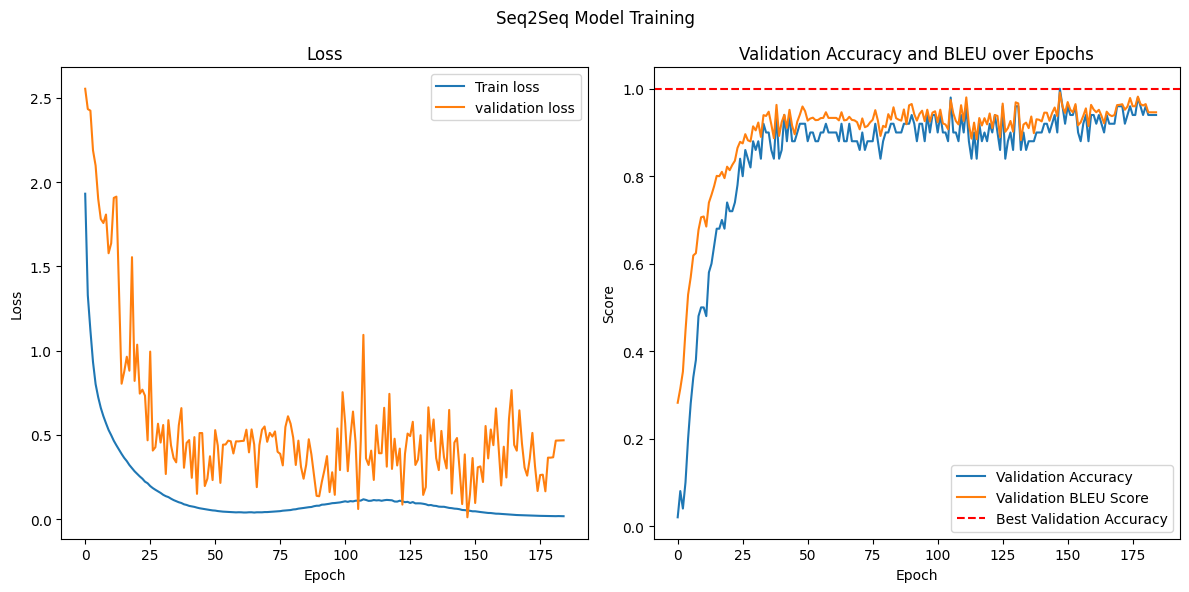

In [36]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(train_losses, label='Train loss')
ax1.plot(val_losses, label='validation loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(val_acces, label='Validation Accuracy')
ax2.plot(val_bleus, label='Validation BLEU Score')
ax2.axhline(y=best_val_acc/100, color='r', linestyle='--', label='Best Validation Accuracy')
ax2.set_title('Validation Accuracy and BLEU over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.legend()

fig.suptitle('Seq2Seq Model Training')

plt.tight_layout()
plt.show()

from datetime import datetime

fig.savefig(f'./assets/seq_{datetime.now().strftime("%Y-%m-%d-%H-%M")}.png')

In [23]:
best_model = TransformerAutoEncoder(embedding_num, embedding_dim, num_layers, num_heads, ff_dim, dropout, MAX_LEN).to(device)
best_model.load_state_dict(torch.load('./data/weights/best_model.pth'))

<All keys matched successfully>

In [24]:
validation(valloader, best_model, device, logout=True)

input: contenpted
pred: contented
target: contented
input: begining
pred: beginning
target: beginning
input: problam
pred: problem
target: problem
input: dirven
pred: driven
target: driven
input: ecstacy
pred: ecstasy
target: ecstasy
input: juce
pred: juice
target: juice
input: localy
pred: locally
target: locally
input: compair
pred: compare
target: compare
input: pronounciation
pred: pronunciation
target: pronunciation
input: transportibility
pred: transportability
target: transportability
input: miniscule
pred: minuscule
target: minuscule
input: independant
pred: independent
target: independent
input: aranged
pred: arranged
target: arranged
input: poartry
pred: poetry
target: poetry
input: leval
pred: level
target: level
input: basicaly
pred: basically
target: basically
input: triangulaur
pred: triangular
target: triangular
input: unexpcted
pred: unexpected
target: unexpected
input: stanerdizing
pred: standardizing
target: standardizing
input: varable
pred: variable
target: variable

(100.0, 0.010744576808065176, 'contented', 'contented', 0.9915143946025495)

In [22]:
validation(testloader, best_model, device, logout=True)

input: apreciate
pred: appreciate
target: appreciate
input: appeciate
pred: appreciate
target: appreciate
input: apprciate
pred: approximate
target: appreciate
input: apprecate
pred: approximate
target: appreciate
input: apprecite
pred: appreciate
target: appreciate
input: luve
pred: love
target: love
input: culd
pred: cold
target: cold
input: heart
pred: heart
target: heart
input: televiseon
pred: television
target: television
input: thone
pred: thong
target: phone
input: phace
pred: phase
target: phase
input: poam
pred: poem
target: poem
input: tomorraw
pred: tomorraw
target: tomorrow
input: presishan
pred: precision
target: precision
input: presishion
pred: precision
target: precision
input: presisian
pred: precision
target: precision
input: presistion
pred: precision
target: precision
input: perver
pred: prever
target: prefer
input: predgudice
pred: prognice
target: prejudice
input: predgudis
pred: proguedies
target: prejudice
input: recievor
pred: receiver
target: receiver
input: 

(68.0, 1.4552611112594604, 'appreciate', 'appreciate', 0.8077906576855058)